# Introduction

this code is from:
https://github.com/PradipNichite/FutureSmart-AI-Blog/blob/main/Multi%20Agent%20system%20with%20LangGraph/Multi_agent_LangGraph.ipynb

the video:
https://www.youtube.com/watch?v=g9E7VNeZItM&t=4s


# First step: run required code for implement the code in colab

In [ ]:
# !pip install python-dotenv
# !pip install langgraph
# !pip install langgraph.checkpoint.sqlite
# !pip install langchain_openai
# !pip install tavily-python

# # install pygraphviz for visualization of the agent graph
# !apt install libgraphviz-dev
# !pip install pygraphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-u

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf sentence-transformers

In [ ]:
from google.colab import userdata
import os
from langchain_community.tools.tavily_search import TavilySearchResults
from tavily import TavilyClient
from langchain_openai import ChatOpenAI


# userdata.get('OPENAI_API_KEY')
# userdata.get('TAVILY_API_KEY')
model = ChatOpenAI(model="gpt-3.5-turbo", api_key = userdata.get('OPENAI_API_KEY'),  temperature=0)

tavily = TavilyClient(api_key=userdata.get('TAVILY_API_KEY'))

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


tavily_tool = TavilySearchResults(max_results=5)

In [ ]:
# import os

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = "" #put your langchain api key here
# os.environ["LANGCHAIN_PROJECT"] = "langgraph_multi_agent_blog"

### Setup API Keys

In [ ]:
# import getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

In [ ]:
# _set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [ ]:
# _set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


### Creating LLM

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o")

### Websearch Tool

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)

### RAG tool

### set folder path in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/Agent_study/Multi-Agent_Supervisor/examples/example_with_RAG/rag_memory/'

In [ ]:
!ls '/content/drive/MyDrive/Agent_study/Multi-Agent_Supervisor/examples/example_with_RAG/rag_memory/'

'2019 - Kim - The role of fuel type and combust.pdf'
'2020 - Weitekamp - Health effects from freshly emitted versus oxidatively or photochemically aged air pollutants.pdf'


In [ ]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document
import os

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 26 documents from the folder.


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 189 chunks.


In [ ]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_db"
)
print("Vector store created and persisted to './chroma_db'")

<ipython-input-40-3b6e8575ed3e>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or dataset

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vector store created and persisted to './chroma_db'


In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("Who was the founder of Futuresmart AI?")
print(retriever_results)

[Document(id='c4c3718f-ed6e-4f1f-9039-2a9cfe6daa58', metadata={'page': 11, 'source': '/content/drive/MyDrive/Agent_study/Multi-Agent_Supervisor/examples/example_with_RAG/rag_memory/2019 - Kim - The role of fuel type and combust.pdf'}, page_content='their careful review of this manuscript. This study was supported by the \nJoint Fire Science Program Project (14-1-04-16) and was performed, \nwhile Dr. Yong Ho Kim held a National Research Council Senior \nResearch Associateship Award at the U.S. Environmental Protection \nAgency. Additional support was provided by the intramural research \nprogram of the Office of Research and Development, U.S. Environ -\nmental Protection Agency, Research Triangle Park, NC. The research \ndescribed in this manuscript has been reviewed by the National Health \nand Environmental Effects Research Laboratory, U.S. Environmental \nProtection Agency, and approved for publication. Approval does not \nsignify that contents necessarily reflect the views and polic

In [ ]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
  """Tool to Retrieve Semantically Similar documents to answer User Questions related to FutureSmart AI"""
  print("INSIDE RETRIEVER NODE")
  retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
  retriever_result = retriever.invoke(question)
  return "\n\n".join(doc.page_content for doc in retriever_results)

### NL2SQL Tool

In [ ]:
!wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

--2025-01-14 05:04:48--  https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite [following]
--2025-01-14 05:04:49--  https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067008 (1.0M) [application/octet-stream]
Saving to: ‘Chinook_Sqlite.sqlite’

Chinook_Sqlite.sqli 100%[===================>]   1.02M  --.-KB/

In [ ]:
!mv Chinook_Sqlite.sqlite Chinook.db

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [ ]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text

In [ ]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
  """Tool to Generate and Execute SQL Query to answer User Questions related to chinook DB"""
  print("INSIDE NL2SQL TOOL")
  execute_query = QuerySQLDataBaseTool(db=db)
  write_query = create_sql_query_chain(llm, db)

  chain = (
      RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
          result=itemgetter("query") | execute_query
      )
  )

  response = chain.invoke({"question": question})
  return response['result']

question = "How many employees are there?"
result = nl2sql_tool.invoke({"question": question})
print(f"Question: {question}")
print(f"Answer: {result}")

INSIDE NL2SQL TOOL


<ipython-input-47-a953639c3dfa>:16: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)


Question: How many employees are there?
Answer: [(8,)]


### Create Supervisor Agent

In [ ]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command


members = ["web_researcher", "rag", "nl2sql"]
# Our supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["web_researcher", "rag", "nl2sql","FINISH"]


def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "rag", "nl2sql", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

### Create Web Research, RAG and NL2SQL Agent

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [ ]:
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast
from langchain_core.language_models import BaseChatModel, LanguageModelLike
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.runnables import (
    Runnable,
    RunnableBinding,
    RunnableConfig,
)
from langchain_core.tools import BaseTool
from typing_extensions import Annotated, TypedDict
from langgraph._api.deprecation import deprecated_parameter
from langgraph.errors import ErrorCode, create_error_message
from langgraph.graph import StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.message import add_messages
from langgraph.managed import IsLastStep, RemainingSteps
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.store.base import BaseStore
from langgraph.types import Checkpointer
from langgraph.utils.runnable import RunnableCallable

class AgentState(TypedDict):
    """The state of the agent."""

    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
      return {"messages": [llm_with_tools.invoke(state["messages"])]}
    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    # Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    graph = graph_builder.compile()
    return graph

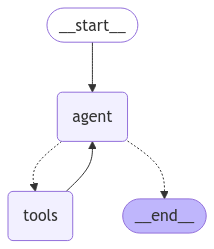

In [ ]:
websearch_agent = create_agent(llm, [web_search_tool])

from IPython.display import Image, display

try:
    display(Image(websearch_agent.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [ ]:
def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

In [ ]:
result = websearch_agent.invoke({"messages": [("user", "what is the weather in delhi today?")]})

In [ ]:
result['messages'][-1].content

'Today in Delhi, the temperature is 18.77°C. The forecast indicates a minimum temperature of 10.05°C and a maximum of 21.61°C.'

In [ ]:
rag_agent = create_agent(llm, [retriever_tool])

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

In [ ]:
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )

In [ ]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)
builder.add_node("nl2sql", nl2sql_node)
graph = builder.compile()

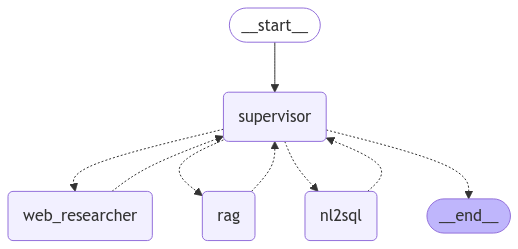

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [ ]:
for s in graph.stream(
    {"messages": [("user", "what is the current weather in Kolkata")]}, subgraphs=True
):
    print(s)
    print("----")

Next Worker: web_researcher
((), {'supervisor': None})
----
(('web_researcher:5defdf5d-df64-bd55-8574-074c19f6f3b0',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9itJYKYvDMNd9GoU4Hco9R27', 'function': {'arguments': '{"query":"current weather in Kolkata"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-06a082ed-6175-4553-b3cc-2ce6c7af4388-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Kolkata'}, 'id': 'call_9itJYKYvDMNd9GoU4Hco9

In [ ]:
input_question = "Find the founder of FutureSmart AI and then do a web research on him"

for s in graph.stream(
    {"messages": [("user", input_question)]}, subgraphs=True
):
    print(s)
    print("----")

Next Worker: rag
((), {'supervisor': None})
----
INSIDE RETRIEVER NODE(('rag:d51300d4-eae3-70d6-a614-94036d4a63a3',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lXEyGG1zJ00cG1PlNtf0TClf', 'function': {'arguments': '{"question":"Who is the founder of FutureSmart AI?"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 70, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-53751759-a015-4259-a70e-6b43f8cd416c-0', tool_calls=[{'name': 'retriever_tool', 'args': {'question': 'Who is the founder of FutureSmart AI?'}, 'id': 'call_lXEyGG1zJ00cG1PlNtf